# Definition of Distribution A
## Setup

In [56]:
from matplotlib import pyplot as plot
from random import uniform
from sympy import Symbol, integrate, lambdify, solve
import pickle

from LocUtil import Grid1, SetSeed

Define constants

In [57]:
nSamp = 100

givenSeed = None
seedDig = 3

nPlot = 101

fileName = 'dist_a.pickle'

Define Symbols

In [58]:
xSym = Symbol('x')    # the random variable

aSym = Symbol('a')    # the probability at x=0
bSym = Symbol('b')    # the probability at x=1

qSym = Symbol('q')    # the quantile

## Define Elements of the Distribution
#### The PDF

In [59]:
form = aSym * (1 - xSym) + bSym * xSym
form

a*(1 - x) + b*x

To be a distribution the total probabilities must be one.  This implies that `a` and `b` are 
dependent.  Solve for `b` and express the distribution only in terms of `a`.

In [60]:
area = integrate(form, (xSym,0,1))
bExp = solve(area - 1, bSym)[0]
bExp

2 - a

Because both `a` and `b` must be non-negative, the range of `a` and `b` is (0,2).

In [61]:
form.subs(bSym, bExp).simplify()

-2*a*x + a + 2*x

In [62]:
pdf = 2*(1 - aSym) * xSym + aSym
pdf

a + x*(2 - 2*a)

In [63]:
def PdfFuncGen(a):
	return lambdify(xSym, pdf.subs(aSym,a).simplify())

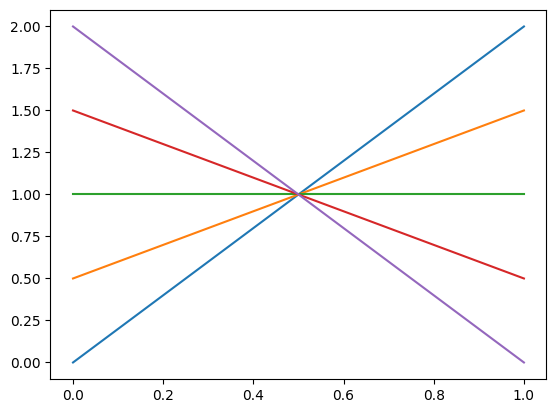

In [64]:
aL = Grid1(0,2,5)
xGrid = Grid1(0,1, nPlot)

for a in aL:
	func = PdfFuncGen(a)
	pdfGrid = [func(x) for x in xGrid]
	plot.plot(xGrid,pdfGrid)

#### The CDF

In [65]:
cdf = integrate(pdf,xSym)
cdf

a*x + x**2*(1 - a)

In [66]:
def CdfFuncGen(a):
	return lambdify(xSym, cdf.subs(aSym, a).simplify())

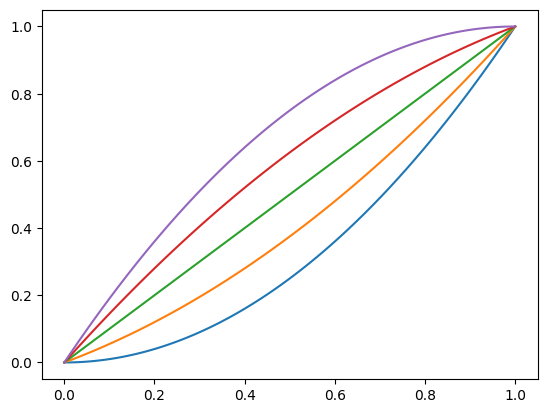

In [67]:
for a in aL:
	func = CdfFuncGen(a)
	cdfGrid = [func(x) for x in xGrid]
	plot.plot(xGrid,cdfGrid)

#### Inverse CDF

In [68]:
temp = solve(cdf - qSym, xSym)
temp

[(a - sqrt(a**2 - 4*a*q + 4*q))/(2*(a - 1)),
 (a + sqrt(a**2 - 4*a*q + 4*q))/(2*(a - 1))]

In [69]:
invCdf = temp[0]
invCdf

(a - sqrt(a**2 - 4*a*q + 4*q))/(2*(a - 1))

There is a removable singularity at a = 1 ... need a library function for dealing with removable singularities. Would need to specify the required accuracy at the transition.

In [70]:
approxAt1 = invCdf.series(aSym,1).simplify().removeO()
approxAt1

q + (a - 1)**5*(21*(2*q - 1)**6 - 35*(2*q - 1)**4 + 15*(2*q - 1)**2 - 1)/32 + (a - 1)**4*(6*q + 7*(2*q - 1)**5 - 10*(2*q - 1)**3 - 3)/16 + (a - 1)**3*(5*(2*q - 1)**4 - 6*(2*q - 1)**2 + 1)/16 + (a - 1)**2*(-2*q + (2*q - 1)**3 + 1)/4 + (a - 1)*((2*q - 1)**2 - 1)/4

In [71]:
def InvCdfFunc(a):
	if abs(a - 1) < 0.01:
		result = approxAt1.subs(aSym,a)
	else:
		result = invCdf.subs(aSym, a).simplify()
	  
	return lambdify(qSym, result)

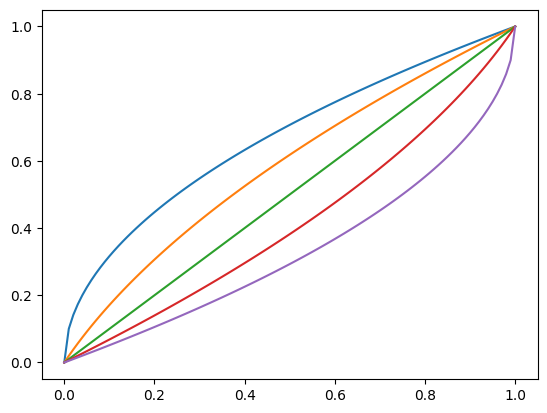

In [72]:
qGrid = Grid1(0,1, nPlot)

for a in aL:
	func = InvCdfFunc(a)
	invCdfGrid = [func(x) for x in xGrid]
	plot.plot(xGrid,invCdfGrid)

## Sample Generation

In [73]:
def GenSamp(a, nSamp):
	sampCdf = [uniform(0,1) for _ in range(nSamp)]
	invCdfFunc = InvCdfFunc(a)
	x = [invCdfFunc(c) for c in sampCdf]
	
	return x

In [74]:
seed = SetSeed(givenSeed, seedDig)
seed

351

In [75]:
a = uniform(0,2)
a

1.715892517717387

Text(0.5, 1.0, 'a = 1.72')

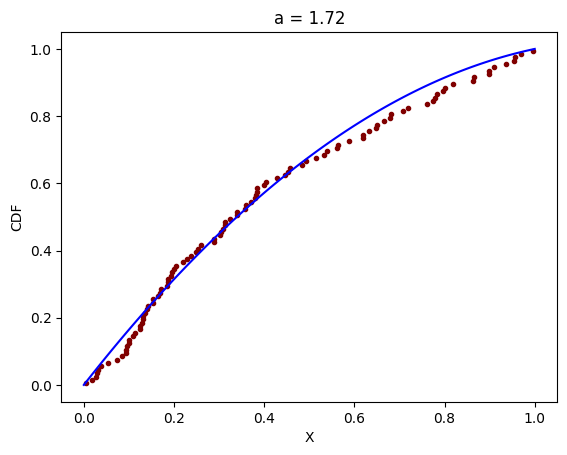

In [76]:
sampSort = sorted(GenSamp(a,nSamp))
quant = [(k + 0.5) / nSamp for k in range(nSamp)]

plot.plot(sampSort,quant, '.', c="Maroon")

xGrid = Grid1(0,1, nPlot)
qGrid = [cdf.subs(aSym,a).subs(xSym,x) for x in xGrid]
plot.plot(xGrid,qGrid, c='Blue')

plot.xlabel('X')
plot.ylabel('CDF')
plot.title(f'a = {a:.2f}')

## Save Results for Reuse

In [77]:
dist = {
	'pdf': pdf, 'PdfFuncGen': PdfFuncGen, 
	'cdf': cdf, 'CdfFuncGen': CdfFuncGen,
	'invCdf': invCdf, 'InvCdfFunGen': InvCdfFunc,
	'GenSamp':  GenSamp
}

In [78]:
with open(fileName, 'wb') as file:
	pickle.dump(dist, file)